In [ ]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import Omniglot
from torch.utils.data import DataLoader
import tempfile

# Omniglot Dataset
- Background: Training, Evaluation: Testing
- There are 50 langauges
- Each language has multiple characters
- There are 964 characters in training set and 659 characters in testing set
- Each character has 20 samples each written by a different person

In [3]:
tmp_dir = tempfile.TemporaryDirectory() # make temp directory for omniglot dataset that can be later cleaned up easily

In [ ]:
transform = transforms.Compose([
    transforms.Resize((28, 28)), # from 105 x 105, to reduce model size and computation
    transforms.ToTensor(), # PIL image to tensor shape (1, 28, 28), and pixel values from 0-255 to 0-1
    transforms.Lambda(lambda x: 1.0 - x),  # Invert the colors, white on black, emperically helps training
])

In [5]:
dataset = Omniglot(
    root=tmp_dir.name,
    background=True, # background characters only, ie training set
    transform=transform,
    download=True
)

100%|██████████| 9.46M/9.46M [00:01<00:00, 8.35MB/s]


Extracting /var/folders/c3/299z_6451mlglnxycxmfkc1c0000gn/T/tmpb1u50ro8/omniglot-py/images_background.zip to /var/folders/c3/299z_6451mlglnxycxmfkc1c0000gn/T/tmpb1u50ro8/omniglot-py


In [6]:
print(type(dataset))
print(f"Total number of images: {len(dataset)}")
print(f"Sample item format: {dataset[0]}")
print(f"Label of first image: {dataset[0][1]}")

<class 'torchvision.datasets.omniglot.Omniglot'>
Total number of images: 19280
Sample item format: (tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.000

In [7]:
print(dataset._characters[0]) 

Gujarati/character42


In [ ]:
print(f"Total character classes: {len(dataset._characters)}") 

Total character classes: 964


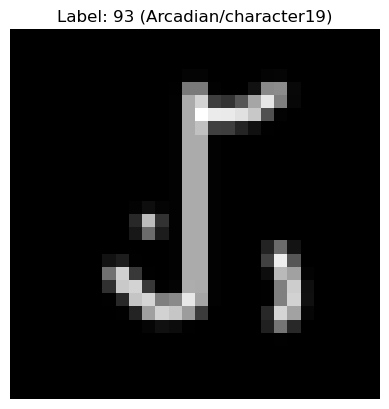

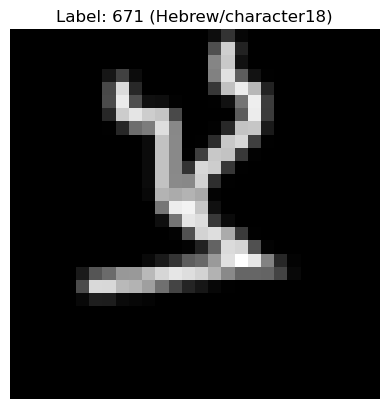

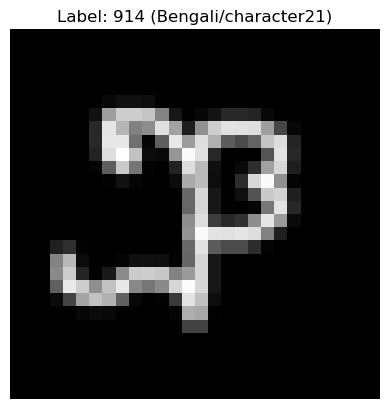

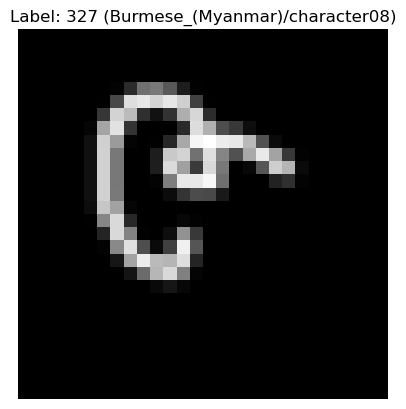

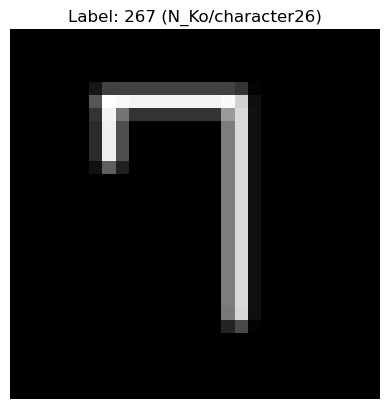

In [9]:
# visualize the samples
import matplotlib.pyplot as plt

def show_image(img_tensor, label=None):
    plt.imshow(img_tensor.squeeze(), cmap='gray') # from (1, 28, 28) to (28, 28), [h,w] for grascale, and [h,w,3] for RGB, [1,h,w] not valid
    if label is not None:
        plt.title(f"Label: {label} ({dataset._characters[label]})")
    plt.axis('off')
    plt.show()

# Display 5 random samples
import random
for _ in range(5):
    idx = random.randint(0, len(dataset) - 1)
    img, label = dataset[idx]
    show_image(img, label)

In [12]:
from collections import Counter

label_counts = Counter(label for _, label in dataset)
print(f"Number of classes: {len(label_counts)}")
print(f"Samples per class (should be 20): {label_counts.most_common(5)}")


Number of classes: 964
Samples per class (should be 20): [(0, 20), (1, 20), (2, 20), (3, 20), (4, 20)]


In [ ]:
label_counts # 964*20 = 19280

Counter({0: 20,
         1: 20,
         2: 20,
         3: 20,
         4: 20,
         5: 20,
         6: 20,
         7: 20,
         8: 20,
         9: 20,
         10: 20,
         11: 20,
         12: 20,
         13: 20,
         14: 20,
         15: 20,
         16: 20,
         17: 20,
         18: 20,
         19: 20,
         20: 20,
         21: 20,
         22: 20,
         23: 20,
         24: 20,
         25: 20,
         26: 20,
         27: 20,
         28: 20,
         29: 20,
         30: 20,
         31: 20,
         32: 20,
         33: 20,
         34: 20,
         35: 20,
         36: 20,
         37: 20,
         38: 20,
         39: 20,
         40: 20,
         41: 20,
         42: 20,
         43: 20,
         44: 20,
         45: 20,
         46: 20,
         47: 20,
         48: 20,
         49: 20,
         50: 20,
         51: 20,
         52: 20,
         53: 20,
         54: 20,
         55: 20,
         56: 20,
         57: 20,
         58: 20,
       